In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
tf.get_default_graph()

num_steps = 5 #number of truncated backprop steps
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

def gen_data(size = 1000000):
    X = np.array(np.random.choice(2,size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    #Partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype = np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype = np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length*i:batch_partition_length*(i+1)]
        data_y[i] = raw_y[batch_partition_length*i:batch_partition_length*(i+1)]
        
    epoch_size = batch_partition_length // num_steps
    for i in range(epoch_size):
        x = data_x[:, i*num_steps:(i+1)*num_steps]
        y = data_y[:, i*num_steps:(i+1)*num_steps]
        yield (x,y)
        
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)
        
x = tf.placeholder(tf.int32, [batch_size, num_steps], name = 'input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name = 'output_placeholder')
init_state = tf.zeros([batch_size, state_size])

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis = 1)

#with tf.variable_scope('rnn_cell'):
    #W = tf.get_variable('W', [num_classes + state_size, state_size])
    #b = tf.get_variable('b', [state_size], initializer = tf.constant_initializer(0.0))
    
def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse = tf.AUTO_REUSE):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer = tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

with tf.variable_scope('softmax'):
    U = tf.get_variable('U', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer = tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, U) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num = num_steps, axis = 1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels = label, logits = logit) for logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

def train_network(num_epochs, num_steps, state_size = 4, verbose = True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print('\nEPOCH', idx)
            for step, (X,Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = sess.run([losses, total_loss, final_state, train_step], feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step%100 == 0 and step > 0:
                    if verbose:
                        print('Average loss at step', step, 'for last 250 steps:', training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
                    
    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.6695639091730118
Average loss at step 200 for last 250 steps: 0.6644347375631332
Average loss at step 300 for last 250 steps: 0.6648193752765655
Average loss at step 400 for last 250 steps: 0.6641255432367325
Average loss at step 500 for last 250 steps: 0.6618608820438385
Average loss at step 600 for last 250 steps: 0.6630625051259994
Average loss at step 700 for last 250 steps: 0.6633562767505645
Average loss at step 800 for last 250 steps: 0.6625136685371399
Average loss at step 900 for last 250 steps: 0.6633644950389862


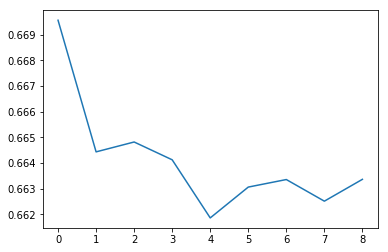

In [2]:
training_losses = train_network(1, num_steps)
plt.plot(training_losses)